In [31]:
import numpy as np
import cupy as cp
from scipy.special import zeta, factorial
import scipy.integrate as integrate
from scipy.stats import norm
B_1 = -zeta(0.5)/np.sqrt(2 * np.pi)

def simMeanMaxGBM(drift, sigma, T, N, m):
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    sims = cp.cumsum(sims, axis=1)
    sims = cp.max(sims, axis=1) # Note all these variables are called sims to be memory efficient
    return cp.mean(cp.exp(sims)), cp.exp(sims)

def exactMeanMaxGBM(r_, sigma, T):
    return (1 + sigma**2 / (2*r_)) * np.exp(r_*T) * norm.cdf((r_ + 0.5 * sigma**2)*T/(sigma * T**0.5)) + \
        norm.cdf(- (r_ - 0.5 * sigma**2) * T / (sigma*T**0.5)) * (1 - sigma**2 / (2 * r_))

# Here we will numerically integrate my own idea, with the correction added later

def toIntegrate(x, r_, sigma, T, m):
    drift = r_ - 1/2 * sigma**2
    def pdf(x):
        sqrtSigmaT = sigma * T**0.5
        return 1/sqrtSigmaT * norm.pdf((x - drift*T)/sqrtSigmaT) - 2 * drift / sigma**2 * np.exp(2 * drift*x / sigma**2) * norm.cdf((-x - drift * T)/sqrtSigmaT) +\
            np.exp(2 * drift * x / sigma**2) * norm.pdf((-x - drift * T)/sqrtSigmaT)/sqrtSigmaT
    def otherPdf(x):
        return 2 / (sigma * np.sqrt(2 * np.pi * T)) * np.exp(-1/(2 * sigma**2 * T) * (x-drift*T)**2) -\
            2 * drift/ sigma**2 * np.exp(2 * drift * x/ sigma**2)*norm.cdf((-x-drift*T)/(sigma * T**0.5))
    return x * pdf(np.log(x) + B_1 * sigma * np.sqrt(T/m) - np.log(S_0)) / x

def simProbMax0(r_, sigma, T, N, m):
    drift = r_ - 1/2 * sigma**2
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = cp.cumsum(sims, axis=1)
    res = cp.any(paths > 0, axis=1)
    return (cp.sum(~res) / N).get()

#Solution of the probability using the theory of Johans paper thm 2.1 (not rewritten) redone later
def exactProbMax0InfTime(r_, sigma, T, m):
    drift = r_ - 1/2 * sigma**2
    if drift >= 0:
        raise Exception("drift is larger or equal to 0, not allowed")
    B = - (drift / sigma) * np.sqrt(T/m) # this is beta
    r_values = np.arange(0, 150)
    zeta_vals = zeta(0.5 - r_values)
    summation = np.sum(zeta_vals/(factorial(r_values)*(2*r_values+1))* (-1)**r_values * (B**2 /2)**r_values)
    return np.exp(B / np.sqrt(2 * np.pi) * summation) * np.sqrt(2) * B

def own_first_order_approx_MC(S_0, r_, sigma, T, N, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * simProbMax0(r_, sigma, T, N, m)) - S_0

def own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * exactProbMax0InfTime(r_, sigma, T, m)) - S_0

def exact_price_cont_time(S_0, r_, sigma, T): # Checked with broadie paper
    return np.exp(-r_*T) * exactMeanMaxGBM(r_, sigma, T) * S_0 - S_0

# print(exact_price_cont_time(100, 0.1, 0.3, 0.5)) # sanity check with Broadie

def broadie_first_order_approx(S_0, r_, sigma, T, m): # checked with broadie
    v = exact_price_cont_time(S_0, r_, sigma, T)
    return (v + S_0) * np.exp(-B_1 * sigma * (T/m)**0.5) - S_0

# print(broadie_first_order_approx(100, 0.1, 0.3, 0.5, 5)) # Sanity check with broadie

def g(t, mu, T, sigma):
    return mu * T**0.5 / sigma * norm.cdf(mu * (T*t)**0.5/sigma) + \
           1 / np.sqrt(2 * np.pi * t) * np.exp(- mu**2 * T * t/(2 * sigma**2))


# todo add that we can add multiple extra terms for diff in mean M and M_tilde
def broadie_second_order_approx(S_0, r_, sigma, T, m):
    v = exact_price_cont_time(S_0, r_, sigma, T)
    mu = r_ - 0.5 * sigma**2
    B_2 = 0.425
    term = 1 - B_1 * sigma * T**0.5/m**0.5 + (2*g(1, mu, T, sigma) * sigma * T**0.5 - mu * T + 2 * B_2 * sigma**2 * T)/ (4*m)
    return (v + S_0) * term - S_0

# print(broadie_second_order_approx(100, 0.1, 0.3, 0.5, 5)) # Sanity check with broadie, note I use the representation of my paper but answers are equivalent
# After much debugging it was found that converting in the last step the Cupy array to Np, took 99.9% of the time, so rewrote it
def sim_price_lookback_put(S_0, r_, sigma, T, N, m, batch_size=100000000):
    # Important second argument is a CUPY array!
    drift = r_ - 0.5 * sigma ** 2
    sims_done = 0
    max_gbws = cp.zeros(N, dtype="float32")
    while sims_done < N:
        N_step = cp.min(np.array([batch_size//m, N - sims_done])).item()
        mean_GBM, max_gbws[sims_done:(sims_done + N_step)] = simMeanMaxGBM(drift, sigma, T, N_step, m)
        sims_done += N_step
    return cp.exp(-r_ * T) * cp.mean(max_gbws, dtype="float64") * S_0 - S_0, max_gbws

In [ ]:
mean, max_gbw = sim_price_lookback_put(100, 0.1, 0.3, 0.5, 10000000, 7)
print(mean, np.mean(max_gbw), np.exp(-0.1*0.5) * 100 * np.std(max_gbw) / np.sqrt(10000000))

x_points = np.arange(1, 101)
sims = np.zeros((x_points.size, 4))
r_ = 0.1
sigma = 0.3
T = 0.5
# from timeit import default_timer as timer # Time simulations
# start = timer()
# sim_price_lookback_put(100, r_, sigma, T, 100000000, 100)
# end = timer()
# print("Time", end - start) # Time in seconds, e.g. 5.38091952400282
# for i in range(0, x_points.size):
#     m = i+1
#     sims[i,:] = np.array([exact_price_cont_time(100, r_, sigma, T), broadie_first_order_approx(100, r_, sigma, T, m)
#         , broadie_second_order_approx(100, r_, sigma, T, m), sim_price_lookback_put(100, r_, sigma, T, 10000000, m)[0]])

In [144]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
plt.plot(x_points, sims[:, 0], label="Continuous time")
plt.plot(x_points, sims[:, 1], label="First order approximation")
plt.plot(x_points, sims[:, 2], label="Second order approximation")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different approximations")
plt.legend()
plt.grid()
plt.show()
plt.savefig('histogram.pgf')

print(sims[79])

<ipython-input-144-d465f421f736>:22: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


ValueError: Error processing '\(\displaystyle {−20}\)'
LaTeX Output:

! Package inputenc Error: Unicode character − (U+2212)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
<*> ...0000}\selectfont \(\displaystyle {−20}\)}
                                                  
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on texput.log.


In [41]:
import pandas as pd
# Table of every 20 points, note first point is m = 1
print(sims[39])
m_points = cp.array(range(19,100,20))
m_points = cp.asnumpy(m_points)
print(sims[m_points, 1:])
df = pd.DataFrame(np.round(sims[m_points, 1:], 5), index=m_points+1, columns=["First order", "Second order"
                                                                ,"Monte-carlo"])
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
print(df)

df.to_latex('differentPricesTable.tex')

[15.35255547 13.12034315 13.24908913 13.23602936]
[[12.20843054 12.46603994 12.44172872]
 [13.12034315 13.24908913 13.23602936]
 [13.52670075 13.61251401 13.60421283]
 [13.76963219 13.83398434 13.83513119]
 [13.93571506 13.98719253 13.98795415]]
m   First order Second order Monte-carlo
20     12.20843     12.46604    12.44173
40     13.12034     13.24909    13.23603
60      13.5267     13.61251    13.60421
80     13.76963     13.83398    13.83513
100    13.93572     13.98719    13.98795


In [38]:
r_ = -0.005
sigma = 0.3
T = 0.5
S_0 = 100
x_points = cp.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i in range(0, x_points.size):
    m = i+1
    sims[i,:] = cp.array([own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m), own_first_order_approx_MC(S_0, r_, sigma, T, 1000000, m)
        , broadie_first_order_approx(S_0, r_, sigma, T, m), sim_price_lookback_put(S_0, r_, sigma, T, 10000000, m)[0]], dtype="float32")
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
np.save("firstOrderApproximations", sims)
np.save("x_pointsfirstOrderApproximations", x_points)

In [41]:
sims = np.load("firstOrderApproximations.npy")
x_points = np.load("x_pointsfirstOrderApproximations.npy")
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
plt.plot(x_points, sims[:, 0], label="Numerical + inf. horizon")
plt.plot(x_points, sims[:, 1], label="Numerical + MC")
plt.plot(x_points, sims[:, 2], label="Theorem 2")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different first order approximations")
plt.legend()
plt.grid()

plt.show()
# plt.savefig('firstOrderApproximations.pgf')

<ipython-input-41-242b8c9c5e4e>:23: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [39]:
# first order approximations with different parameters

r_ = -0.1
sigma = 0.5
T = 5
S_0 = 100
x_points = cp.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i in range(0, x_points.size):
    m = i+1
    sims[i,:] = cp.array([own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m), own_first_order_approx_MC(S_0, r_, sigma, T, 1000000, m)
        , broadie_first_order_approx(S_0, r_, sigma, T, m), sim_price_lookback_put(S_0, r_, sigma, T, 10000000, m)[0]], dtype="float32")
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
np.save("firstOrderApproximationsPic2", sims)
np.save("x_pointsfirstOrderApproximationsPic2", x_points)

In [40]:
sims = np.load("firstOrderApproximationsPic2.npy")
x_points = np.load("x_pointsfirstOrderApproximationsPic2.npy")
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
plt.plot(x_points, sims[:, 0], label="Numerical + inf. horizon")
plt.plot(x_points, sims[:, 1], label="Numerical + MC")
plt.plot(x_points, sims[:, 2], label="Theorem 2")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different first order approximations")
plt.legend()
plt.grid()

plt.show()
# plt.savefig('firstOrderApproximations.pgf')

<ipython-input-40-00add435194d>:23: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [26]:
# TODOOOO KIJKEN NAAR relative error van continue prijs tov de echte discrete prijs.
# HANGT DIT AF VAN PARAMETERS??!?!??! GAAT VOORAL OVER m van 50 -> 200, paar plotjes en met random distributies doen.
# U GOT THIS (LATER KUNNEN DE PLOTJES NOGMOOI GEMAAKTWORDEN, zie HUGO zijn ding

r_ = 0.05
sigma = 0.3
T = 0.5
S_0 = 100
# First the plot with r deviating
r_points = np.array([-0.5, -0.2,-0.05,0.002, 0.05, 0.1, 0.15, 0.20])
x_points = np.arange(10, 101, 2)
sims = cp.zeros((x_points.size, r_points.size))
for i,  m in enumerate(x_points):
    for idx, r_ in enumerate(r_points): # TODO REDO THIS CHART N = 10m instead of 1m
        #disc_price = sim_price_lookback_put(S_0, r_, sigma, T, 1000000, m)[0]
        disc_price = broadie_second_order_approx(S_0, r_, sigma, T, m)
        cont_price = exact_price_cont_time(S_0, r_, sigma, T)
        sims[i,idx] = (cont_price - disc_price)/disc_price
sims = cp.asnumpy(sims)
np.save("relativeErrorr_deviations", sims)
np.save("x_pointsRelativeErrorr_deviations", x_points)

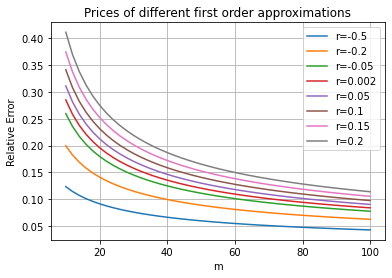

In [27]:
# A plot differing r_
sims = np.load("relativeErrorr_deviations.npy")
x_points = np.load("x_pointsRelativeErrorr_deviations.npy")
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
for idx, r_ in enumerate(r_points):
    plt.plot(x_points, sims[:, idx], label=f"r={r_}")

plt.xlabel("m")
plt.ylabel("Relative Error")
plt.title("Prices of different first order approximations")
plt.legend()
plt.grid()

plt.show()
# TODO this code needs to be finished with my pc, because laptop is too slow. Also add picture for sigma and other T and for
# Changing two parameters add once, but probably Second order approximation is necessary.

In [15]:
# This looks at convergence speed for large m.

r_ = 0.05
sigma = 0.3
T = 0.5
S_0 = 100
x_points = np.logspace(0, 10, 1000, dtype="uint")
sims = np.zeros(x_points.size)
for i,  m in enumerate(x_points):
    #disc_price = sim_price_lookback_put(S_0, r_, sigma, T, 1000000, m)[0]
    disc_price = broadie_second_order_approx(S_0, r_, sigma, T, m)
    cont_price = exact_price_cont_time(S_0, r_, sigma, T)
    sims[i] = (cont_price - disc_price)/disc_price
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig, ax = plt.subplots()
plt.plot(x_points, sims, label="RE")
ax.loglog()
plt.xlabel("m")
plt.ylabel("Relative Error")
plt.title("Error of continuous price compared to discrete price")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.savefig("convergenceRelativeErrorContinuous.pgf")

In [32]:
# Calculate the relative error distribution for different random parameters for large m
N = 1000000 # Number of samples
r_draws = np.random.uniform(-0.05, 0.25, N)
sigma_draws = np.random.uniform(0.05, 0.5, N)
T_draws = np.random.uniform(0.1, 5, N)
S_0 = 100
x_points = np.array([10**2, 10**3, 10**4, 10**5, 10**6])
sims = np.zeros((N, x_points.size))
for i,  m in enumerate(x_points):
    disc_price = broadie_second_order_approx(S_0, r_draws, sigma_draws, T_draws, m)
    cont_price = exact_price_cont_time(S_0, r_draws, sigma_draws, T_draws)
    sims[:, i] = (cont_price - disc_price)/disc_price
print(np.mean(sims[:,1]))

0.050143148728270144


In [37]:
# generate the plots and table
import pandas as pd
m_points = x_points
data = np.array([np.mean(sims, axis=0),np.std(sims, axis=0),np.median(sims, axis=0)]).T
df = pd.DataFrame(np.round(data, 5), index=m_points, columns=["Mean", "Std", "Median"])
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
df.to_latex("randomParametersRelativeErrorContPriceLargem.tex")
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    "axes.unicode_minus": False
})
fig, ax = plt.subplots()
weights = np.ones_like(sims[:,3]) / len(sims[:,3])
ax.hist(sims[:,3], weights=weights, bins=100)
ax.set_title("Histogram of relative error")
ax.set_xlabel("Relative Error")
fig.savefig("distributionRandomParametersLargem.pgf")

In [3]:
# Generate same plot as introduction but with a confidence interval and also a table
r_ = 0.1
sigma = 0.3
T = 0.5
S_0 = 100
N = 10000000

In [ ]:
x_points = np.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i, m in enumerate(x_points):
    sims[i,0], max_gbws = sim_price_lookback_put(S_0, r_, sigma, T, N, m)
    sims[i,1] = cp.std(cp.exp(-r_ * T) * max_gbws * S_0 - S_0)
    sims[i,2], max_gbws = sim_price_lookback_put(S_0, r_, sigma, T, N//100, m)
    sims[i,3] = cp.std(cp.exp(-r_ * T) * max_gbws * S_0 - S_0)

sims = cp.asnumpy(sims)
np.save("monteCarloWithConfidenceInterval", sims)
np.save("m_pointsMonteCarloWithConfidenceInterval", x_points)

In [30]:
import matplotlib.pyplot as plt
import matplotlib
sims = np.load("monteCarloWithConfidenceInterval.npy")
m_points = np.load("m_pointsMonteCarloWithConfidenceInterval.npy")
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig, ax = plt.subplots()
ax.plot(m_points[50:],sims[50:,0], label="N=10m")
ci = sims[50:,1]/np.sqrt(N)
ax.fill_between(m_points[50:], (sims[50:,0]-1.96*ci), (sims[50:,0]+1.96*ci), color='b', alpha=.2)
ax.plot(m_points[50:],sims[50:,2],label="N=100000")
ci = sims[50:,3]/np.sqrt(N/100)
ax.fill_between(m_points[50:], (sims[50:,2]-1.96*ci), (sims[50:,2]+1.96*ci), color='r', alpha=.1)
plt.grid()
ax.set_xlabel("m")
ax.set_ylabel("Price")
ax.legend(loc="upper left")
ax.set_title("Monte Carlo estimations with 95% confidence interval")
plt.savefig("MonteCarloEstWith95CI.pgf")
# Create the table
import pandas as pd
sims = sims[:, [0,1]]
sims[:,1] = sims[:,1]/np.sqrt(N)
sims = np.c_[sims, sims[:,0] - 1.96 * sims[:,1],sims[:,0] + 1.96 * sims[:,1]]
sims = sims[19::20]
df = pd.DataFrame(np.round(sims, 5), index=m_points[19::20], columns=["Mean", "S.E.", "95% lower limit", "95% higher limit"])
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
df.to_latex("TableMonteCarloWithCI.tex")

In [3]:
from timeit import default_timer as timer
# Generate time plots
r_ = 0.05
sigma = 0.3
T = 0.5
S_0 = 100
N_true = 100000000 # 1 billion draws to simulate the "true" price

m_points = np.arange(1, 101, 2)
sims = np.zeros((m_points.size, 4)) # Contains mean est, the std and broadie second-order approx
for i, m in enumerate(m_points):
    start = timer()
    sims[i,0], max_gbws = sim_price_lookback_put(S_0, r_, sigma, T, N_true, m)
    sims[i,3] = timer() - start
    std_est = cp.sqrt(cp.mean(max_gbws**2, dtype="float64") - cp.mean(max_gbws, dtype="float64")**2)
    sims[i,1] = np.exp(-r_ * T) * std_est.item() * S_0
    max_gbws = None
    sims[i,2] = broadie_second_order_approx(S_0, r_, sigma, T, m)
    if i % 10 == 1:
        print(i)
np.save("simulationsForTimeGraph", sims)

1
11
21
31
41


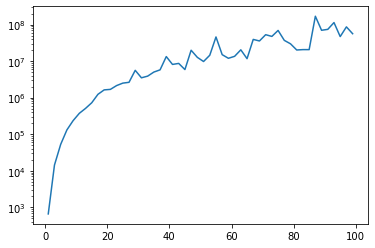

In [10]:
# Do calculations and plot graph
sims = np.load("simulationsForTimeGraph.npy")
second_order_approx_error = np.abs(sims[:,2] - sims[:, 0])
N_equivalent = (1.96 * sims[:,1]/second_order_approx_error)**2   # The N for which the error is at most the Monte Carlo error with 95% prob
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(m_points, N_equivalent)

In [ ]:
from timeit import default_timer as timer
# Generate time plots
r_ = 0.05
sigma = 0.3
T = 0.5
S_0 = 100
N_true = 1000000000 # 1 billion draws to simulate the "true" price

m_points = np.arange(1, 101, 2)
sims = np.zeros((m_points.size, 4)) # Contains mean est, the std and broadie second-order approx
for i, m in enumerate(m_points):
    start = timer()
    current_mean_price = 0
    sumOfSquares = 0
    sumOfEach = 0
    steps = N_true // 100000000
    if N_true % 100000000 != 0:
        raise Exception("N_true multiple of 100 million")
    for j in range(steps):
        new_price, max_gbws = sim_price_lookback_put(S_0, r_, sigma, T, N_true//steps, m)
        current_mean_price += 1/steps * new_price
        sumOfSquares += cp.sum(max_gbws**2, dtype="float64")
        sumOfEach += cp.sum(max_gbws, dtype="float64")
        max_gbws = None
    std_est = cp.sqrt(sumOfSquares/N_true - (sumOfEach/N_true)**2)
    sims[i,3] = timer() - start
    sims[i,1] = np.exp(-r_ * T) * std_est.item() * S_0
    sims[i,2] = broadie_second_order_approx(S_0, r_, sigma, T, m)
    if i % 10 == 1:
        print(i)
np.save("simulationsForTimeGraph", sims)

In [85]:
# table time idea
from timeit import default_timer as timer
S_0 = 100
r_ = 0.1
sigma = 0.3
T = 0.5
N_std = 10000000 # Number of paths to estimate std of price
sims = cp.zeros((m_points.size, 6)) # Left to right: true price, 2nd order, std, absolute error, N_equivalent, time to calc
m_points = np.array([5, 10, 20, 40, 80, 160])
sims[:,0] = cp.array([10.06425,11.39775,12.44463,13.23942,13.82950,14.26104])
for i, m in enumerate(m_points):
    sims[i, 1] = broadie_second_order_approx(S_0, r_, sigma, T, m)
    max_gbws = sim_price_lookback_put(S_0, r_, sigma, T, N_std, m)[1]
    sims[i, 2] = cp.std(cp.exp(-r_ * T) * max_gbws * S_0 - S_0, dtype="float64")
    # Measuring time to calculate the price
    sims[i, 3] = np.abs(sims[i, 1] - sims[i, 0])
    sims[i, 4] = int((1.96 * sims[i ,2]/sims[i, 3])**2)
    start = timer()
    price_x = sim_price_lookback_put(S_0, r_, sigma, T, int(sims[i, 4]), m)[0]
    sims[i, 5] = timer() - start
np.save("simulationsTimeTableData", cp.asnumpy(sims))

In [141]:
import pandas as pd
# Create the table
sims = np.load("simulationsTimeTableData.npy")
data = sims[:, [0, 1, 3, 4, 5]]
df = pd.DataFrame(np.round(data, 5), index=m_points, columns=["True price", "2nd-order", "Abs error", "N equivalent", "Seconds"])
df["N equivalent"] = pd.to_numeric(df["N equivalent"], downcast="integer")
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
print(df)
df.to_latex("simulationsTimeTable.tex", escape=False, header=["True price", "2nd-order", "Abs error", r"$\tilde{N}$", "Seconds"])

m    True price  2nd-order  Abs error  N equivalent  Seconds
5      10.06425   10.18203    0.11778         69122  0.00152
10     11.39775   11.44688    0.04913        405116  0.00149
20     12.44463   12.46604    0.02141       2170561  0.00070
40     13.23942   13.24909    0.00967      10789237  0.00164
80     13.82950   13.83398    0.00448      50701557  0.00848
160    14.26104   14.26317    0.00213     227039988  0.07622


           3             2
1.006e+04 x - 2.115e+05 x + 3.466e+06 x - 1.695e+07


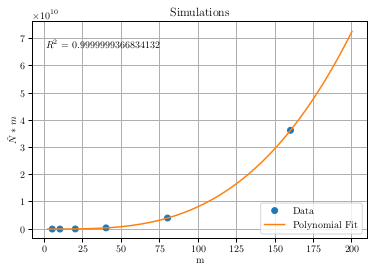

In [130]:
# Draw a graph with computation time as number of draws
computing_time = data[:, 3] * m_points
popt = np.polyfit(m_points, computing_time, 3)
polyEst = np.poly1d(popt)
xx = np.linspace(2, 200, 100)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig, ax = plt.subplots()
ax.plot(m_points, computing_time, "o", label="Data")
ax.plot(xx, polyEst(xx), label="Polynomial Fit")
ax.grid()
r_squared = 1 - np.sum((polyEst(m_points)-computing_time)**2)/np.sum((computing_time - np.mean(computing_time))**2)
ax.text(0.04, 0.88, f"$R^2$ = {r_squared}", transform=plt.gca().transAxes)
plt.legend(loc="lower right")
ax.set_xlabel("m")
ax.set_ylabel(r"$\tilde{N}*m$")
ax.set_title("Simulations");
plt.savefig("SimulationTimePlotAsDraws.pgf")
print(polyEst)

           3             2
2.034e-08 x - 1.293e-07 x - 3.396e-05 x + 0.001661


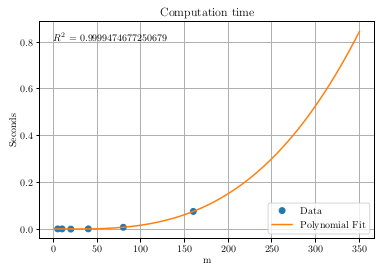

In [131]:
# Draw a graph with computation time in seconds
computing_time = sims[:,5]
popt = np.polyfit(m_points, computing_time, 3)
polyEst = np.poly1d(popt)
xx = np.linspace(2, 350, 200)
fig, ax = plt.subplots()
ax.plot(m_points, computing_time, "o", label="Data")
ax.plot(xx, polyEst(xx), label="Polynomial Fit")
ax.grid()
r_squared = 1 - np.sum((polyEst(m_points)-computing_time)**2)/np.sum((computing_time - np.mean(computing_time))**2)
ax.text(0.04, 0.91, f"$R^2$ = {r_squared}", transform=plt.gca().transAxes)
plt.legend(loc="lower right")
ax.set_xlabel("m")
ax.set_ylabel("Seconds")
ax.set_title("Computation time");
plt.savefig("SimulationTimePlotAsSeconds.pgf")
print(polyEst)